本数据集来自某公司人力资源的数据库，记录了员工的各种特征属性，我们通过数据挖掘来探索员工离职率与哪些因素有较强的关联

# 第一部分: 取得数据
***

In [3]:
# 引入必要的数据预处理库和可视化工具
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
%matplotlib inline


In [4]:
#读取数据并将其存入dataframe的数据结构中并命名为"df"
df = pd.read_csv('Ch3-Turnover.csv', index_col=None)

# 第二部分: 清洗数据 
***

*通常，清理数据需要做很多工作，而且可能是一个非常繁琐的过程。来自kaggle的这个数据集是clean的，不包含丢失的值。但是，仍然需要检查数据集，以确保其他内容都是可读的，并且观察值与属性名称匹配。.*

In [5]:
# 检查是否存在缺失值
df.isnull().any()

satisfaction_level       False
last_evaluation          False
number_project           False
average_montly_hours     False
time_spend_company       False
Work_accident            False
left                     False
promotion_last_5years    False
sales                    False
salary                   False
dtype: bool

In [9]:
# 快速了解我们在数据集中要处理的内容

df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [10]:
#重命名某些列以提高可读性
df = df.rename(columns={'satisfaction_level': 'satisfaction', 
                        'last_evaluation': 'evaluation',
                        'number_project': 'projectCount',
                        'average_montly_hours': 'averageMonthlyHours',
                        'time_spend_company': 'yearsAtCompany',
                        'Work_accident': 'workAccident',
                        'promotion_last_5years': 'promotion',
                        'sales' : 'department',
                        'left' : 'turnover'
                        })

In [11]:
# 将响应变量“离职率”移到表的前面
front = df['turnover']
df.drop(labels=['turnover'], axis=1,inplace = True)
df.insert(0, 'turnover', front)
df.head()

,turnover,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,promotion,department,salary
0,1,0.38,0.53,2,157,3,0,0,sales,low
1,1,0.80,0.86,5,262,6,0,0,sales,medium
2,1,0.11,0.88,7,272,4,0,0,sales,medium
3,1,0.72,0.87,5,223,5,0,0,sales,low
4,1,0.37,0.52,2,159,3,0,0,sales,low


# Part 3: 探索数据

##  3a. 统计概况
***
该数据集包含：
 - 大约15000名雇员的情况和10项属性
 - 公司的离职率大约为24%
 - 雇员的平均满意度为0.61

In [12]:
# 数据集包含14999名雇员的情况和10项属性
df.shape

(14999, 10)

In [9]:
#检查属性的类型
df.dtypes

turnover                 int64
satisfaction           float64
evaluation             float64
projectCount             int64
averageMonthlyHours      int64
yearsAtCompany           int64
workAccident             int64
promotion                int64
department              object
salary                  object
dtype: object

In [10]:
#看起来大约76%的员工留下了，24%的员工离开了。 
#注：在进行交叉验证时，保持离职率不变是重要的
turnover_rate = df.turnover.value_counts() / len(df)
turnover_rate

0    0.761917
1    0.238083
Name: turnover, dtype: float64

In [11]:
#显示员工的统计概览
df.describe()

,turnover,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,promotion
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.238083,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.021268
std,0.425924,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.144281
min,0.000000,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000
25%,0.000000,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000
50%,0.000000,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000
75%,0.000000,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000


In [12]:
# 总计概况 (离职 V.S.不离职)
turnover_Summary = df.groupby('turnover')
turnover_Summary.mean()

,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,promotion
turnover,,,,,,,
0,0.666810,0.715473,3.786664,199.060203,3.380032,0.175009,0.026251
1,0.440098,0.718113,3.855503,207.419210,3.876505,0.047326,0.005321


##  3b. 相关性矩阵 & 热图
***
**中度正相关特征:** 
- projectCount vs evaluation: 0.349333
- projectCount vs averageMonthlyHours:  0.417211
- averageMonthlyHours vs evaluation: 0.339742

**中度负相关特征:**
 - satisfaction vs turnover:  -0.388375

**停下来思考一下:**
- 哪些特征对我们的目标变量影响最大（离职率）?
- 哪些特征之间有很强的相关性?
- 我们能对这些特征做一个更深入的挖掘吗?

**总结:**

从热图上看,projectCount, averageMonthlyHours, and evaluation之间存在 **正相关(+)** 关系. 这可能意味着花更多时间和做更多项目的员工会得到高度评价。

从**负相关(-)** 关系上看, turnover 和 satisfaction 高度相关. 可以认为当人们不太满意的时候，他们更倾向于离开公司。

,turnover,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,promotion
turnover,1.000000,-0.388375,0.006567,0.023787,0.071287,0.144822,-0.154622,-0.061788
satisfaction,-0.388375,1.000000,0.105021,-0.142970,-0.020048,-0.100866,0.058697,0.025605
evaluation,0.006567,0.105021,1.000000,0.349333,0.339742,0.131591,-0.007104,-0.008684
projectCount,0.023787,-0.142970,0.349333,1.000000,0.417211,0.196786,-0.004741,-0.006064
averageMonthlyHours,0.071287,-0.020048,0.339742,0.417211,1.000000,0.127755,-0.010143,-0.003544
yearsAtCompany,0.144822,-0.100866,0.131591,0.196786,0.127755,1.000000,0.002120,0.067433
workAccident,-0.154622,0.058697,-0.007104,-0.004741,-0.010143,0.002120,1.000000,0.039245
promotion,-0.061788,0.025605,-0.008684,-0.006064,-0.003544,0.067433,0.039245,1.000000


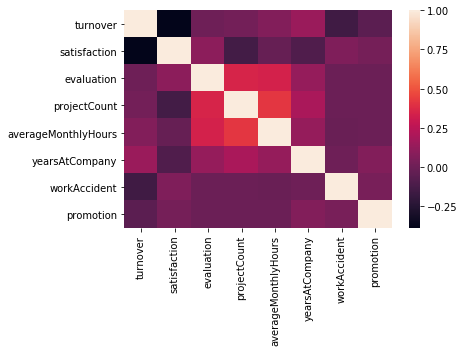

In [13]:
#相关性矩阵
corr = df.corr()
corr = (corr)
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

corr

##  3c. 分布图 (Satisfaction - Evaluation - AverageMonthlyHours)
***
**结论:** 观察员工的一些features的分布， 以下是可以得出的结论:
 - **Satisfaction** - 低满意度和高满意度的员工数量较多.
 - **Evaluation** - 对于低评价（低于0.6）和高评价（高于0.8），员工分布呈双峰分布。
 - **AverageMonthlyHours** - 还存在另一种员工平均月工作时数的双峰分布（少于150小时，多于250小时）。
 - 评价和月平均工作时数的分布较为相似。 
 - 月平均工时较低的员工评价较低，反之亦然。
 - 如果回顾一下相关系数矩阵，评价和月平均工时数之间的高相关性确实支持这一结论。
 
**停下来思考一下:** 
 - 低满意度的员工较多有什么原因？
 - 员工是否可以按照这些特征进行分组？
 - 评价和月平均工作时数是否有所关联？

Text(0, 0.5, 'Employee Count')

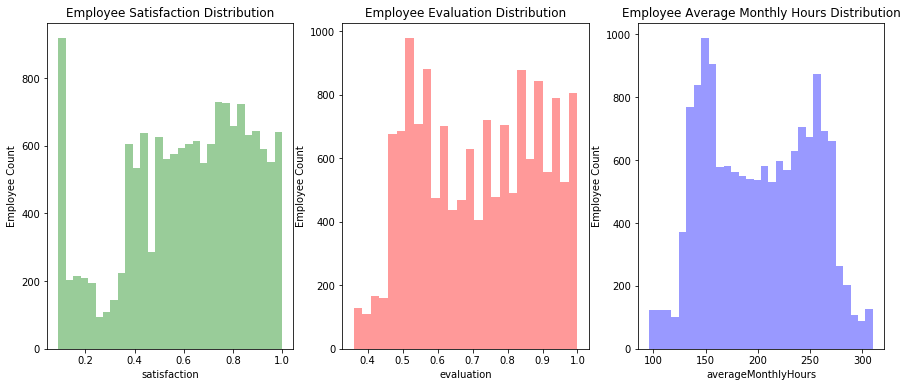

In [14]:
# Set up the matplotlib figure
f, axes = plt.subplots(ncols=3, figsize=(15, 6))

# Graph Employee Satisfaction
sns.distplot(df.satisfaction, kde=False, color="g", ax=axes[0]).set_title('Employee Satisfaction Distribution')
axes[0].set_ylabel('Employee Count')

# Graph Employee Evaluation
sns.distplot(df.evaluation, kde=False, color="r", ax=axes[1]).set_title('Employee Evaluation Distribution')
axes[1].set_ylabel('Employee Count')

# Graph Employee Average Monthly Hours
sns.distplot(df.averageMonthlyHours, kde=False, color="b", ax=axes[2]).set_title('Employee Average Monthly Hours Distribution')
axes[2].set_ylabel('Employee Count')

##  3d. 薪水 V.S. 离职率
***
**结论:** 这并不罕见. 以下是通过数据挖掘所能发现的:
 - 离职员工中的大部分都有着**低 或 中等**的薪水。
 - 很少有**高**薪水的员工离开。
 - 工资低到平均水平的员工倾向于离开公司。
 
**停下来思考一下:** 
 - 低、中、高薪的工作环境是什么样的？
 - 是什么致使高薪员工离开?

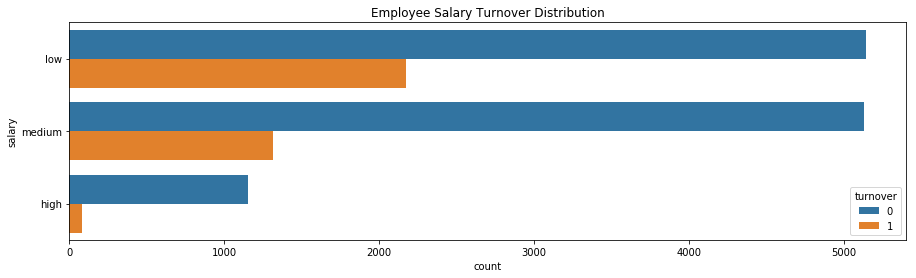

In [15]:
f, ax = plt.subplots(figsize=(15, 4))
sns.countplot(y="salary", hue='turnover', data=df).set_title('Employee Salary Turnover Distribution');

##  3e. 所在部门 V.S. 离职率
***
**结论** 观察有关于部门的更多信息，以下是可以得出的结论:
 - **sales, technical 和 support department** 是离职人员数量top 3的部门
 - management 部门的离职率最低
 
**停下来思考:** 
 - 如果对每个部门都有着更多的信息，能确定员工离职的更直接原因吗?

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

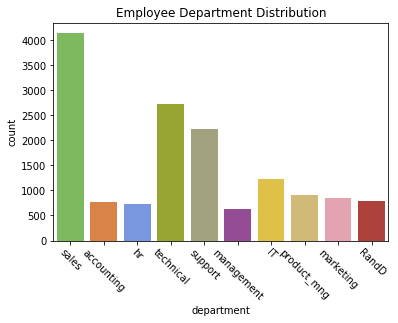

In [16]:
# Employee distri
# Types of colors
color_types = ['#78C850','#F08030','#6890F0','#A8B820','#A8A878','#A040A0','#F8D030',  
                '#E0C068','#EE99AC','#C03028','#F85888','#B8A038','#705898','#98D8D8','#7038F8']

# Count Plot (a.k.a. Bar Plot)
sns.countplot(x='department', data=df, palette=color_types).set_title('Employee Department Distribution');
 
# Rotate x-labels
plt.xticks(rotation=-45)

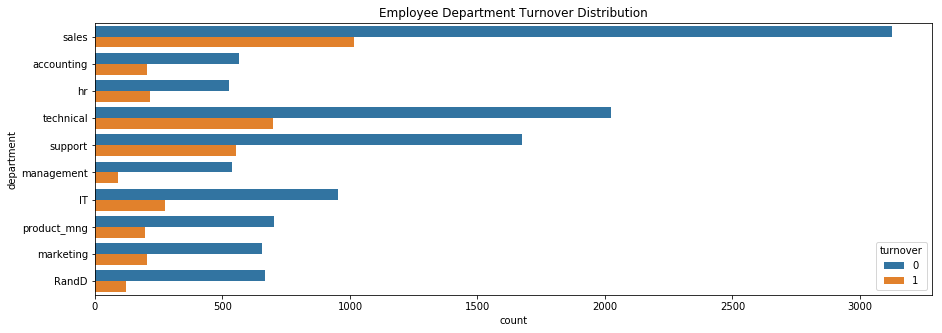

In [17]:
f, ax = plt.subplots(figsize=(15, 5))
sns.countplot(y="department", hue='turnover', data=df).set_title('Employee Department Turnover Distribution');

##  3f. 离职率 V.S.项目数
***
**结论:** . 这是分析后可以得出的结论:
 - 有**2,6和7**个项目的员工中一半多都离开了公司
 - 大多数没有离开公司的员工有 **3,4和 5**个项目。
 - 有 **7** 个项目的员工全都离开了公司。
 - 随着项目数量的增加，员工的离职率上升。
 
**停下来思考:** 
 - 为什么员工会在项目数量较低/较高的范围内离职？
 - 这是否意味着项目数为2或以下的员工工作不够努力或价值不高，从而离开公司？
 - 有6个以上项目的员工是否因过度工作而离开公司？



[Text(0, 0.5, 'Percent')]

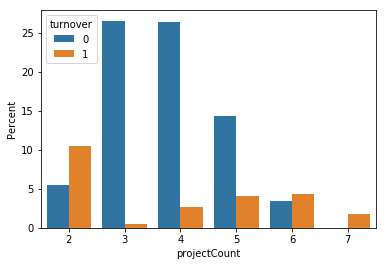

In [18]:
ax = sns.barplot(x="projectCount", y="projectCount", hue="turnover", data=df, estimator=lambda x: len(x) / len(df) * 100)
ax.set(ylabel="Percent")

##  3g. 离职率 V.S. 评价
***
**结论:** 
 - 离职率和评价间存在双峰分布。
 - 有着**low** 表现的员工更倾向于离开公司。
 - 有着 **high** 表现的员工也更倾向于离开公司。
 - 对于员工来讲具有 **0.6-0.8** 的评价是一个**舒适区**。

Text(0.5, 1.0, 'Employee Evaluation Distribution - Turnover V.S. No Turnover')

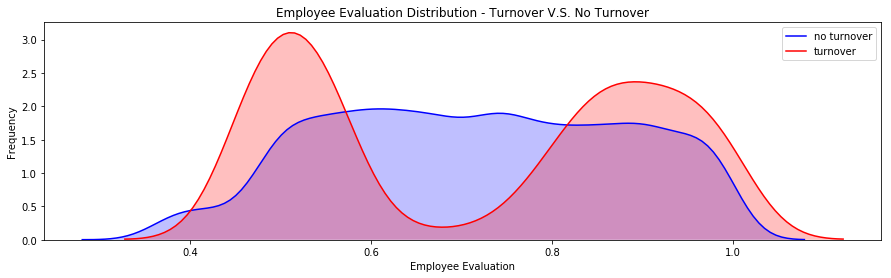

In [19]:
# 核密度图
fig = plt.figure(figsize=(15,4),)
ax=sns.kdeplot(df.loc[(df['turnover'] == 0),'evaluation'] , color='b',shade=True,label='no turnover')
ax=sns.kdeplot(df.loc[(df['turnover'] == 1),'evaluation'] , color='r',shade=True, label='turnover')
ax.set(xlabel='Employee Evaluation', ylabel='Frequency')
plt.title('Employee Evaluation Distribution - Turnover V.S. No Turnover')

##  3h. 离职率 V.S. 每月工时
***
**结论:** 
 - 离职率和每月工时之间同样存在双峰分布 
 - 每月工时过短 **(~150hours or less)** 的员工更倾向于离职。
 - 每月工时过长 **(~250 or more)** 的员工更倾向于离职。
 - 离开的员工通常是**工作不足**或**工作过度**。

Text(0.5, 1.0, 'Employee AverageMonthly Hours Distribution - Turnover V.S. No Turnover')

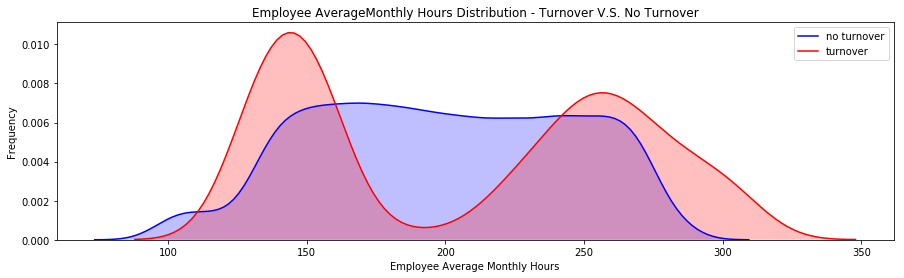

In [20]:
#核密度估计图
fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(df.loc[(df['turnover'] == 0),'averageMonthlyHours'] , color='b',shade=True, label='no turnover')
ax=sns.kdeplot(df.loc[(df['turnover'] == 1),'averageMonthlyHours'] , color='r',shade=True, label='turnover')
ax.set(xlabel='Employee Average Monthly Hours', ylabel='Frequency')
plt.title('Employee AverageMonthly Hours Distribution - Turnover V.S. No Turnover')

##  3i. 离职率 V.S. 满意度 
***
**结论:** 
 - 离职率和满意度之间存在三峰分布 
 - 满意度过低 **(0.2 or less)** 的员工倾向于离开公司
 - 满意度较低 **(0.3~0.5)** 的员工倾向于离开公司
 - 满意度很高 **(0.7 or more)** 的员工倾向于离开公司

Text(0.5, 1.0, 'Employee Satisfaction Distribution - Turnover V.S. No Turnover')

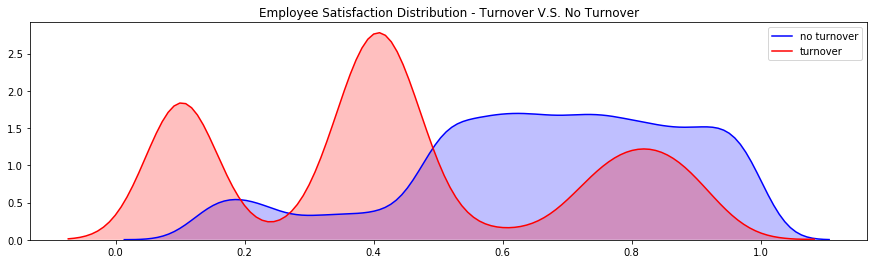

In [21]:
#核密度估计图
fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(df.loc[(df['turnover'] == 0),'satisfaction'] , color='b',shade=True, label='no turnover')
ax=sns.kdeplot(df.loc[(df['turnover'] == 1),'satisfaction'] , color='r',shade=True, label='turnover')
plt.title('Employee Satisfaction Distribution - Turnover V.S. No Turnover')

##  3j. 项目数 VS 月平均工时
***

**总结:**
 - 随着项目数量的增加，每月平均工作时间也在增加
 - 箱线图的一个奇怪之处在于，离职的人和没有离职的人在平均小时数上的差异。
 - 尽管项目增加了，那些**没有**离职的员工有基本**不变的**平均工作时间，
 - 相比之下，那些**离职**的员工平均工作时间随着项目的增加而增加。

**停下来思考:** 
 - 这可能意味着什么？ 
 - **为什么即使在同一个项目中，离职的员工比不离职的员工工作时间更长？**

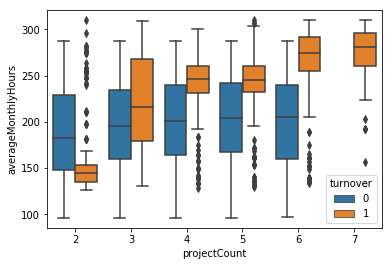

In [22]:
#ProjectCount VS AverageMonthlyHours [箱线图]
#看起来平均每个月工作200小时的员工留在了公司。那些平均每月工作250小时或每月工作150小时的人离职了。

import seaborn as sns
sns.boxplot(x="projectCount", y="averageMonthlyHours", hue="turnover", data=df)

##  3k. 项目数 VS 评价
***
**结论:** 这个图看起来与上面的图非常相似。奇怪的是，完成更多项目的离职员工的评价有所提高。但是，对于未离职员工来说，尽管项目数量有所增加，未离职员工的评价却没有变化。 

**需要思考的问题:**
 - **为什么当项目数量有所增加时离职员工的平均评价要高于未离职员工？**
 - 评价较低的员工不应该更倾向于离开公司吗？

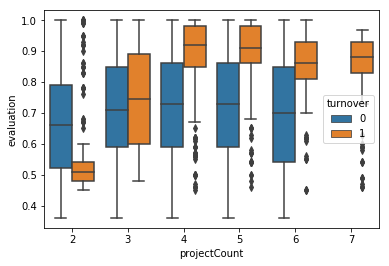

In [23]:
#ProjectCount VS Evaluation
#Looks like employees who did not leave the company had an average evaluation of around 70% even with different projectCounts
#There is a huge skew in employees who had a turnover though. It drastically changes after 3 projectCounts. 
#Employees that had two projects and a horrible evaluation left. Employees with more than 3 projects and super high evaluations left
import seaborn as sns
sns.boxplot(x="projectCount", y="evaluation", hue="turnover", data=df)

##  3l. 满意度 VS 评价
***
**结论:** 这是迄今为止最引人注目的图表。以下是可以发现的结论：
 - 离开公司的员工有 **3** 个不同的集群
 
**Cluster 1 (勤奋工作并且不开心的员工):** 满意度低于0.2，评价高于0.75。这可能是一个很好的迹象，表明离开公司的员工都是好员工，但对自己的工作感觉很糟糕。
 - **Question:** 当你被高度评价的时候，是什么原因让员工感觉如此糟糕？会不会太辛苦了？这个集群是否意味着“过度工作”的员工？

**Cluster 2 (评价低并且不开心的员工):** 满意度在0.35~0.45之间，评价在0.58以下。这可以被看作是在工作中受到了不好的评价和感觉不好的员工。
 - **Question:** 这个集群是否意味着“表现不佳”的员工？

**Cluster 3 (勤奋工作并且开心的员工):** 满意度在0.7～1.0之间，评价大于0.8。这可能意味着这个集群中的员工是“理想的”。他们热爱自己的工作，并因工作表现而受到高度评价。
 - **Question:** 这个集群是否意味着员工离开是因为他们找到了另一个工作机会？

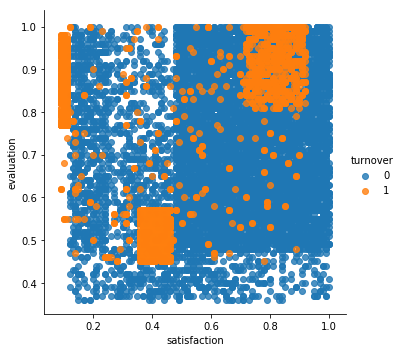

In [24]:
sns.lmplot(x='satisfaction', y='evaluation', data=df,
           fit_reg=False, # No regression line
           hue='turnover')   # Color by evolution stage

##  3m. 离职率 V.S. 工作年限
***
**结论:** 是否存在一个员工离开公司临界点。
 - 在工作了**4和5**年的员工中，有一半以上离开了公司
 - 有5年工作年限的员工应该被 **高度** 重视
 
**停下来思考:** 
 - 为什么大多员工在**3-5**年内离职？
 - 离开的员工有哪些特征？
 - 这些雇员是兼职的还是全职的？

[Text(0, 0.5, 'Percent')]

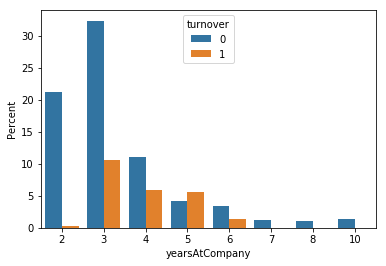

In [25]:
ax = sns.barplot(x="yearsAtCompany", y="yearsAtCompany", hue="turnover", data=df, estimator=lambda x: len(x) / len(df) * 100)
ax.set(ylabel="Percent")

## 3n. 离职员工的K-Mean 聚类
***
**Cluster 1 (Blue):** 勤奋工作并且不开心的员工

**Cluster 2 (Red):** 评价低并且不开心的员工

**Cluster 3 (Green):** 勤奋工作并且开心的员工

**有关聚类的问题:**
    - 如何知道有3个类
    - 需要专家领域的知识来分类适当数量的集群
    - 可能存在隐藏的未知结构

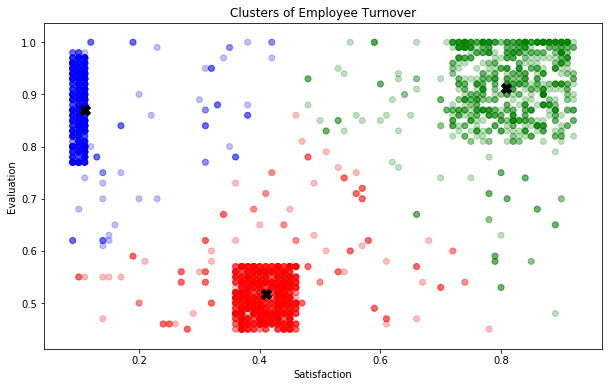

In [26]:
# Import KMeans Model
from sklearn.cluster import KMeans

# Graph and create 3 clusters of Employee Turnover
kmeans = KMeans(n_clusters=3,random_state=2)
kmeans.fit(df[df.turnover==1][["satisfaction","evaluation"]])

kmeans_colors = ['green' if c == 0 else 'blue' if c == 2 else 'red' for c in kmeans.labels_]

fig = plt.figure(figsize=(10, 6))
plt.scatter(x="satisfaction",y="evaluation", data=df[df.turnover==1],
            alpha=0.25,color = kmeans_colors)
plt.xlabel("Satisfaction")
plt.ylabel("Evaluation")
plt.scatter(x=kmeans.cluster_centers_[:,0],y=kmeans.cluster_centers_[:,1],color="black",marker="X",s=100)
plt.title("Clusters of Employee Turnover")
plt.show()

# 特征的重要性
***
**结论:**

通过使用决策树分类器，它可以对用于预测的特征进行排序。前三个特征是员工满意度、工作年限和评价。这有助于创建我们的回归模型，因为当我们使用较少的特征时，理解模型中的内容会更容易理解。

**Top 3 Features:**
1. Satisfaction（满意度）
2. YearsAtCompany（工作年限）
3. Evaluation（评价）


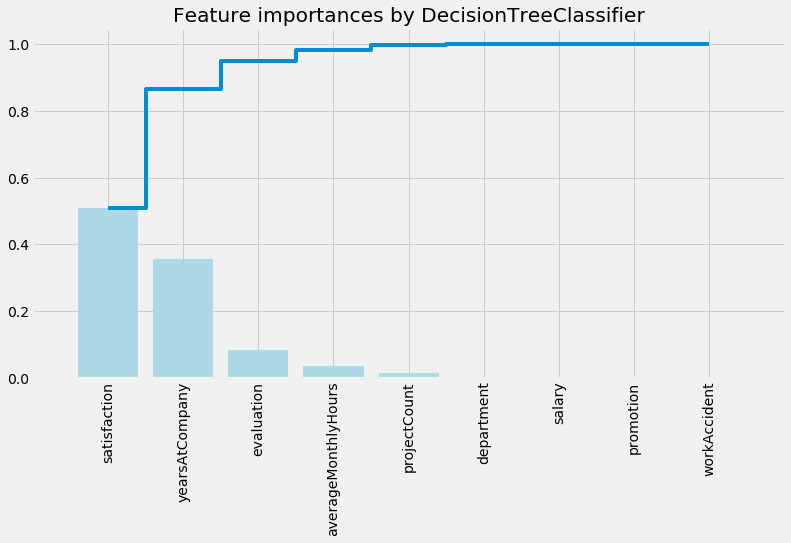

In [27]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12,6)

# Renaming certain columns for better readability
df = df.rename(columns={'satisfaction_level': 'satisfaction', 
                        'last_evaluation': 'evaluation',
                        'number_project': 'projectCount',
                        'average_montly_hours': 'averageMonthlyHours',
                        'time_spend_company': 'yearsAtCompany',
                        'Work_accident': 'workAccident',
                        'promotion_last_5years': 'promotion',
                        'sales' : 'department',
                        'left' : 'turnover'
                        })

# Convert these variables into categorical variables
df["department"] = df["department"].astype('category').cat.codes
df["salary"] = df["salary"].astype('category').cat.codes

# Create train and test splits
target_name = 'turnover'
X = df.drop('turnover', axis=1)


y=df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, random_state=123, stratify=y)

dtree = tree.DecisionTreeClassifier(
    #max_depth=3,
    class_weight="balanced",
    min_weight_fraction_leaf=0.01
    )
dtree = dtree.fit(X_train,y_train)

## plot the importances ##
importances = dtree.feature_importances_
feat_names = df.drop(['turnover'],axis=1).columns


indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.title("Feature importances by DecisionTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()